<a href="https://colab.research.google.com/github/ngca1011/sentiment-classifier/blob/main/sentiment_classification_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Review:
    def __init__(self, text, score):
        self.text = str(text)
        self.score = score
        self.sentiment = self.get_sentiment()

    def get_sentiment(self):
        if (self.score >= 3):
            return "POSITIVE"
        else:
            return "NEGATIVE"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Extract data

In [3]:
filename = "/content/drive/MyDrive/Colab Notebooks/data/Books_rating.csv"
import pandas as pd
df = pd.read_csv(filename, nrows = 100000)

### Cleansing data

In [4]:
df[['review/text', 'review/score']].isnull().sum()
df['review/text'].dropna()

0        This is only for Julie Strain fans. It's a col...
1        I don't care much for Dr. Seuss but after read...
2        If people become the books they read and if "t...
3        Theodore Seuss Geisel (1904-1991), aka &quot;D...
4        Philip Nel - Dr. Seuss: American IconThis is b...
                               ...                        
99995    I somewhat liked april morning. It was a quick...
99996    I somewhat liked april morning. It was a quick...
99997    I enjoyed this book very much. Although it was...
99998    I have read the novel, April Morning, and i fo...
99999    If you want to read an outstanding book about ...
Name: review/text, Length: 100000, dtype: object

### Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

reviews = [Review(df.loc[i]['review/text'], df.loc[i]['review/score']) for i in range(len(df))]

X = [x.text for x in reviews]
y = [y.sentiment for y in reviews]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

### Text preprocessing

In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# https://stackoverflow.com/questions/66044999/remove-stopwords-in-tensorflow-extended
def parse_text(text):
    text = re.sub("[^a-zA-Z]", ' ', text) # Remove punctuation and numbers

    text = text.lower().split() # Lowercase and split

    swords = set(stopwords.words("english"))
    text = [w for w in text if w not in swords] # Remove stop words

    text = " ".join(text)
    return text

X_train = [parse_text(text) for text in X_train]
X_test = [parse_text(text) for text in X_test]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Tokenize and pad the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(X_train[0])
print(X_train_sequences[0])

max_len = max(len(seq) for seq in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen = max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_len)

read book boy mother autographed copy book gives realistic tale life like leading wounded knee massacre
[2, 1, 349, 271, 16248, 360, 1, 221, 806, 218, 13, 5, 1442, 4981, 7809, 7858]


In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode labels ('POSITIVE' and 'NEGATIVE') to numerical values (0 and 1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### Train the model

In [9]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential()

# Layers for training
model.add(Embedding(input_dim = len(tokenizer.word_index) + 1,
                    output_dim = 100,
                    input_length = max_len)) # Input layer
model.add(Dropout(0.5)) # Dropout layer
model.add(LSTM(units = 100,
               return_sequences = False)) # LSTM layer
model.add(Dense(units = 64,
                activation = 'relu',
                kernel_regularizer = regularizers.l2(0.1))) # L2 regularizer
model.add(Dense(units = 1,
                activation = 'sigmoid')) # Output layer

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = losses.BinaryCrossentropy(from_logits=False),
              metrics = tf.metrics.BinaryAccuracy(threshold=0.5))

# Early stopping
callback = EarlyStopping(monitor = 'val_loss',
                         patience = 3,
                         restore_best_weights = True)

# Start to train the model
history = model.fit(X_train_padded,
                    y_train_encoded,
                    epochs = 15,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [callback])

Epoch 1/15
2000/2000 [==============================] - 349s 172ms/step - loss: 0.5424 - binary_accuracy: 0.8792 - val_loss: 0.2604 - val_binary_accuracy: 0.9056
Epoch 2/15
2000/2000 [==============================] - 224s 112ms/step - loss: 0.2106 - binary_accuracy: 0.9222 - val_loss: 0.2333 - val_binary_accuracy: 0.9105
Epoch 3/15
2000/2000 [==============================] - 217s 108ms/step - loss: 0.1642 - binary_accuracy: 0.9413 - val_loss: 0.2489 - val_binary_accuracy: 0.9152
Epoch 4/15
2000/2000 [==============================] - 204s 102ms/step - loss: 0.1247 - binary_accuracy: 0.9583 - val_loss: 0.2540 - val_binary_accuracy: 0.9121
Epoch 5/15
2000/2000 [==============================] - 208s 104ms/step - loss: 0.0960 - binary_accuracy: 0.9695 - val_loss: 0.2802 - val_binary_accuracy: 0.9116


### Plot the model's evaluation

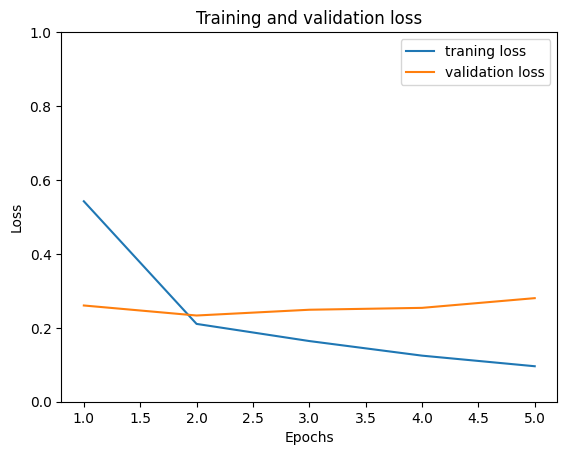

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label = 'traning loss')
plt.plot(epochs, history.history['val_loss'], label = 'validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

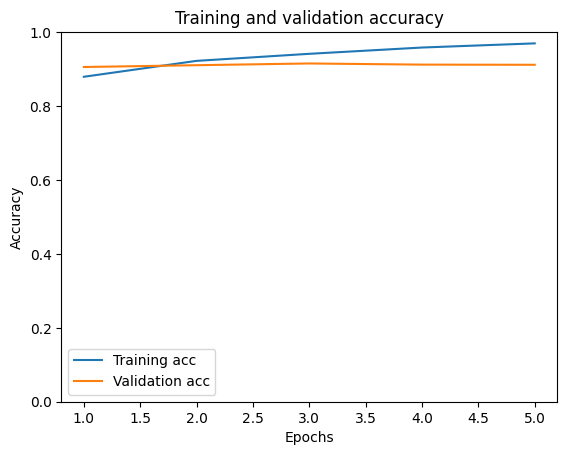

In [11]:
plt.plot(epochs, history.history['binary_accuracy'], label='Training acc')
plt.plot(epochs, history.history['val_binary_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

### Test

In [12]:
# Evaluate the model on the test set
results = model.evaluate(X_test_padded, y_test_encoded)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

625/625 [==============================] - 21s 34ms/step - loss: 0.2196 - binary_accuracy: 0.9190
Test Loss: 0.21955882012844086
Test Accuracy: 0.9190000295639038


In [13]:
def convert(p):
    if (p < 0.5): return 'NEGATIVE'
    else: return 'POSITIVE'
new_test = ['I hate this book', 'Bad horrible', 'Trash book', 'I enjoyed it', 'Amazing book', 'This book is a masterpiece', 'What a waste of time']
new_test_sequences = tokenizer.texts_to_sequences(new_test)
new_test_padded = pad_sequences(new_test_sequences, maxlen=max_len)

predictions = [convert(p) for p in model.predict(new_test_padded)]
print(predictions)

1/1 [==============================] - 0s 410ms/step
['NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE']
